2024-12-11 13:40:23,305 [INFO] utils.settings: Loaded config from C:\Users\petre\Documents\GitHub\MATSimPipeline/settings.yaml
2024-12-11 13:40:26,783 [WARNING] utils.data_frame_processor: DataFrame is not yet initialized.
2024-12-11 13:40:26,784 [INFO] utils.data_frame_processor: DataFrame loaded and concatenated successfully from CSV.
2024-12-11 13:40:27,291 [WARNING] utils.data_frame_processor: DataFrame is not yet initialized.
2024-12-11 13:40:27,293 [INFO] utils.data_frame_processor: DataFrame loaded and concatenated successfully from CSV.


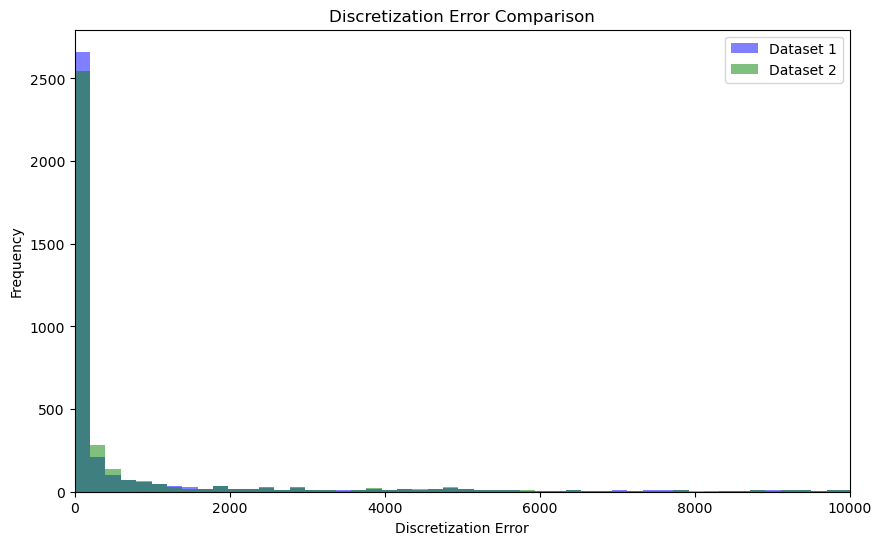

In [1]:
import numpy as np
from utils import helpers as h
from utils import settings as s
from analysis import analysis
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the necessary functions and classes are imported from 'analysis' and 'h'

# First Dataset -> Hoerl
Data1 = analysis.DataframeAnalysis()
Data1.load_df_from_csv(r'C:\Users\petre\Documents\GitHub\MATSimPipeline\output\20241210_175510\location_assignment_result_load_main_hoerl.csv')
Data1.df = Data1.df[Data1.df['to_location'].notna()]
Data1.df['from_location'] = Data1.df['from_location'].apply(h.convert_to_point)
Data1.df['to_location'] = Data1.df['to_location'].apply(h.convert_to_point)
Data1.evaluate_distance_deviations_from_df()

# Second Dataset -> Advanced Petre
Data2 = analysis.DataframeAnalysis()
Data2.load_df_from_csv(r'C:\Users\petre\Documents\GitHub\MATSimPipeline\output\20241210_182050\location_assignment_result_load_main_advanced_petre_100-branches.csv')
Data2.df = Data2.df[Data2.df['to_location'].notna()]
Data2.df['from_location'] = Data2.df['from_location'].apply(h.convert_to_point)
Data2.df['to_location'] = Data2.df['to_location'].apply(h.convert_to_point)
Data2.evaluate_distance_deviations_from_df()

# Ensure the maximum value is limited to 1000
# Data1.df['discretization_error'] = Data1.df['discretization_error'].clip(upper=1000)
# Data2.df['discretization_error'] = Data2.df['discretization_error'].clip(upper=1000)

# Plotting in the same plot
plt.figure(figsize=(10, 6))

# Plot histogram for Dataset 1
Data1.df['discretization_error'].plot.hist(bins=100, alpha=0.5, color='blue', label='Dataset 1')

# Plot histogram for Dataset 2
Data2.df['discretization_error'].plot.hist(bins=100, alpha=0.5, color='green', label='Dataset 2')

# Adding title and labels
plt.title('Discretization Error Comparison')
plt.xlabel('Discretization Error')
plt.ylabel('Frequency')
plt.xlim(0, 10000)
plt.legend()

plt.show()


In [34]:
# Sum up discretization errors for each person
hoerl_errors = Data1.df.groupby('unique_person_id')['discretization_error'].sum().reset_index()
hoerl_errors.rename(columns={'discretization_error': 'hoerl_error'}, inplace=True)

advanced_petre_errors = Data2.df.groupby('unique_person_id')['discretization_error'].sum().reset_index()
advanced_petre_errors.rename(columns={'discretization_error': 'advanced_petre_error'}, inplace=True)

# Merge the summed errors for comparison
merged_df = hoerl_errors.merge(advanced_petre_errors, on='unique_person_id')

# Add the error ratio column
merged_df['error_ratio'] = merged_df['advanced_petre_error'] / merged_df['hoerl_error']

# Filter for cases where advanced Petre has a higher error than Hoerl
worse_cases = merged_df[merged_df['advanced_petre_error'] > merged_df['hoerl_error']]
worse_cases = worse_cases.sort_values(by='error_ratio', ascending=False)

# Filter for cases where advanced Petre has a lower error than Hoerl
better_cases = merged_df[merged_df['advanced_petre_error'] < merged_df['hoerl_error']]
better_cases = better_cases.sort_values(by='error_ratio')

# Filter for cases where advanced Petre and Hoerl have equal errors
equal_cases = merged_df[merged_df['advanced_petre_error'] == merged_df['hoerl_error']]

print(f"Better cases: {len(better_cases)}")
print(f"Worse cases: {len(worse_cases)}")
print(f"Equal cases: {len(equal_cases)}")

worse_cases
# # Save the results
# worse_cases.to_csv('worse_cases.csv', index=False)
# better_cases.to_csv('better_cases.csv', index=False)
# equal_cases.to_csv('equal_cases.csv', index=False)

Better cases: 237
Worse cases: 261
Equal cases: 502


,unique_person_id,hoerl_error,advanced_petre_error,error_ratio
366,10258160_11815_10258162,67.430203,9839.723459,145.924570
584,10429660_11971_10429661,82.859286,5307.024432,64.048638
548,10402660_11947_10402661,227.622737,8967.270101,39.395318
357,10248630_11809_10248631,114.559459,4294.070912,37.483338
273,10202280_11760_10202281,249.800942,8009.051613,32.061735
...,...,...,...,...
846,10648060_12159_10648061,9189.028110,9209.366344,1.002213
671,10494660_12028_10494661,8370.000000,8384.731643,1.001760
511,10363620_11920_10363621,20222.843314,20252.200425,1.001452
875,10677300_12177_10677301,13049.498934,13065.386059,1.001217


mean, median, plot deviation dist, the same per chain, -- capacity matching??

In [37]:
from analysis import plotting
plotting.plot_person_plan("10298230_11857_10298232", Data1.df, Data2.df)

In [6]:
Data1.df['discretization_error'].describe()

count     3728.000000
mean       906.321462
std       2294.653863
min          0.016987
25%         17.822270
50%         68.883000
75%        296.954014
max      19800.000000
Name: discretization_error, dtype: float64

In [7]:
Data2.df['discretization_error'].describe()


count     3728.000000
mean       938.264789
std       2345.433069
min          0.018922
25%         14.505945
50%         55.187174
75%        374.914620
max      19800.000000
Name: discretization_error, dtype: float64

In [39]:
# Filter df for a specific person
person_id = '10298230_11857_10298232'
person_df1 = Data1.df[Data1.df['unique_person_id'] == person_id]
person_df2 = Data2.df[Data2.df['unique_person_id'] == person_id]
person_df2

,H_ID,H_GEW,H_HOCH,MODE,BASISAUF,TEILSTP,M_CAR,H_ART,H_GR,hhgr_gr,...,home_to_main_time_is_estimated,home_to_main_distance_is_estimated,to_activity_with_connected,home_location,to_act_name,from_location,to_location,to_act_identifier,placed_distance,discretization_error
1551,10298230,0.341114,89.330375,2,2,1,0,2,7,5,...,0.0,0.0,business,[ 551461.68016588 5807385.68658411],['nan'],POINT (551461.68016588 5807385.68658411),POINT (552431.72487358 5798895.94213403),['3600315132'],8544.983766,5.016234
1552,10298230,0.341114,89.330375,2,2,1,0,2,7,5,...,0.0,0.0,home,[ 551461.68016588 5807385.68658411],NaN,POINT (552431.72487358 5798895.94213403),POINT (551461.68016588 5807385.68658411),NaN,8544.983766,5.016234
1553,10298230,0.341114,89.330375,2,2,1,0,2,7,5,...,0.0,0.0,return_journey,[ 551461.68016588 5807385.68658411],NaN,POINT (551461.68016588 5807385.68658411),POINT (559618.57017058 5806879.28326678),[['1642878452']],8172.594378,377.405622
1554,10298230,0.341114,89.330375,2,2,1,0,2,7,5,...,0.0,0.0,home,[ 551461.68016588 5807385.68658411],NaN,POINT (559618.57017058 5806879.28326678),POINT (551461.68016588 5807385.68658411),NaN,8172.594378,377.405622
1555,10298230,0.341114,89.330375,2,2,1,0,2,7,5,...,0.0,0.0,return_journey,[ 551461.68016588 5807385.68658411],NaN,POINT (551461.68016588 5807385.68658411),POINT (559618.57017058 5806879.28326678),[['1642878452']],8172.594378,377.405622
1556,10298230,0.341114,89.330375,2,2,1,0,2,7,5,...,0.0,0.0,home,[ 551461.68016588 5807385.68658411],NaN,POINT (559618.57017058 5806879.28326678),POINT (551461.68016588 5807385.68658411),NaN,8172.594378,377.405622
1557,10298230,0.341114,89.330375,2,2,1,0,2,7,5,...,0.0,0.0,return_journey,[ 551461.68016588 5807385.68658411],NaN,POINT (551461.68016588 5807385.68658411),POINT (559618.57017058 5806879.28326678),[['1642878452']],8172.594378,377.405622
1558,10298230,0.341114,89.330375,2,2,1,0,2,7,5,...,0.0,0.0,home,[ 551461.68016588 5807385.68658411],NaN,POINT (559618.57017058 5806879.28326678),POINT (551461.68016588 5807385.68658411),NaN,8172.594378,377.405622
